In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import math

from datetime import datetime

## Data

### Trading Dates

First, just a list of trading dates to backtest

In [104]:
TRADING_DATES_FILE_PATH = 'trading_dates.csv'
def load_trading_dates(): 
  return pd.to_datetime(
    pd.read_csv(TRADING_DATES_FILE_PATH, header=None)[0],
  )

In [105]:
TRADING_DATES = load_trading_dates()
TRADING_DATES

0     2000-01-21
1     2000-02-18
2     2000-03-17
3     2000-04-20
4     2000-05-19
         ...    
229   2019-02-15
230   2019-03-15
231   2019-04-18
232   2019-05-17
233   2019-06-21
Name: 0, Length: 234, dtype: datetime64[ns]

### SPX Index Data



In [106]:
SPX_PRICES_FILE_PATH = 'spx_index_prices.csv'
SPX_PRICES_DATE_COL = 'Date'
SPX_PRICES_OPEN_COL = 'Open'
SPX_PRICES_CLOSE_COL = 'Close'
SPX_PRICES_AVG_COL = 'Avg'
def load_spx_prices():
  spx_prices = pd.read_csv(SPX_PRICES_FILE_PATH)
  spx_prices[SPX_PRICES_DATE_COL] = pd.to_datetime(spx_prices[SPX_PRICES_DATE_COL])
  spx_prices[SPX_PRICES_AVG_COL] = ((spx_prices[SPX_PRICES_OPEN_COL] + spx_prices[SPX_PRICES_CLOSE_COL]) / 2)
  
  return spx_prices

In [107]:
STOCK_PRICES = load_spx_prices()
STOCK_PRICES

,Date,Open,High,Low,Close,Adj Close,Volume,Avg
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1462.234985
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1427.320007
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1400.765015
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.779968
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1422.459961
...,...,...,...,...,...,...,...,...
5081,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2447.359985
5082,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2477.424926
5083,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2417.300049
5084,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2401.434936


### SPX Options Data

Now, a whole 600MBs of options data

In [108]:
SPX_OPTION_PRICES_FILE_PATH = 'spx_option_prices.csv'
OPTION_PRICES_DATE_COL = 'date'
OPTION_PRICES_EXPIRATION_COL = 'exdate'
OPTION_PRICES_MATURITY_COL = 'maturity'
OPTION_PRICES_STRIKE_COL = 'strike_price'
OPTION_PRICES_BID_COL = 'best_bid'
OPTION_PRICES_OFFER_COL = 'best_offer'
OPTION_PRICES_SPREAD_COL = 'spread'
OPTION_PRICES_AVG_COL = 'avg'
OPTION_PRICES_DATE_FMT = '%Y%m%d'

def load_option_prices():
  option_prices = pd.read_csv(SPX_OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [109]:
OPTION_PRICES = load_option_prices()
OPTION_PRICES

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
0,108105,2000-01-03,2000-03-18,19991229.0,P,1410.0,36.750,38.750,0,1,...,235.99500,-119.41110,10120210,1470.521157,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,108105,2000-01-03,2000-01-22,19991223.0,P,1505.0,55.250,57.250,0,50,...,100.89450,-172.62950,10000760,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,108105,2000-01-03,2000-06-17,20000103.0,P,1350.0,40.750,42.750,290,14570,...,311.57080,-66.86736,10016917,1490.761534,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,108105,2000-01-03,2000-01-22,20000103.0,P,1500.0,51.625,53.625,57,505,...,105.71350,-186.79210,10149633,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,108105,2000-01-03,2000-01-22,NaN,P,1540.0,84.875,86.875,0,0,...,68.56206,-96.37443,10056576,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,108105,2019-06-28,2020-06-30,NaN,P,3800.0,824.100,848.000,0,0,...,NaN,NaN,129500433,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,108105,2019-06-28,2020-06-30,NaN,P,3900.0,921.200,945.200,0,0,...,NaN,NaN,129500434,2942.162769,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,108105,2019-06-28,2020-06-30,NaN,P,4000.0,1018.700,1042.500,0,0,...,NaN,NaN,129500435,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,108105,2019-06-28,2020-06-30,NaN,P,4100.0,1116.100,1140.000,0,0,...,NaN,NaN,129500436,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## Data Model

Now that we have some data. Let's create data structures for our trading.

### Portfolio

Let's create a concept of a portfolio. We'll use this data structure to record the state of our assets in a trading day. This can record our SPX quantity, the options we bought, and the cash we have on hand

In [110]:
PORTFOLIO_CASH = 'cash'
PORTFOLIO_SPX_ORDER = 'spx_order'
PORTFOLIO_OPTION_ORDER = 'option_order'
PORTFOLIO_QUANTITY = 'quantity'
PORTFOLIO_STRIKE = 'strike'
PORTFOLIO_EXPIRATION = 'exdate'

def build_portfolio(spx_order, option_order, cash):
  return {
    PORTFOLIO_SPX_ORDER: spx_order, 
    PORTFOLIO_OPTION_ORDER: option_order,
    PORTFOLIO_CASH: cash
  }

def build_spx_order(quantity):
  return {PORTFOLIO_QUANTITY: quantity}

def build_option_order(quantity, strike, expiration_date):
  return {
      PORTFOLIO_QUANTITY: quantity, 
      PORTFOLIO_STRIKE: strike, 
      PORTFOLIO_EXPIRATION: expiration_date
  }

To get a sense of it, here's how it would look if we owned 60 shares of SPX, 

In [111]:
EXAMPLE_PORTFOLIO = build_portfolio(
    spx_order=build_spx_order(quantity=60),
    option_order=build_option_order(
        quantity=100, strike=1400, expiration_date=datetime(2000, 1, 4)
    ),
    cash=100000
)
EXAMPLE_PORTFOLIO

{'spx_order': {'quantity': 60},
 'option_order': {'quantity': 100,
  'strike': 1400,
  'exdate': datetime.datetime(2000, 1, 4, 0, 0)},
 'cash': 100000}

## Trade Book

Next, let's create a dataframe to keep track of our portfolio every trading day. We can use this to measure our performance down the road. 

Let's add some helper functions, merge portfolios

In [112]:
def is_same_option_contract(option_order_a, option_order_b):
    return (
        (option_order_a[PORTFOLIO_STRIKE] == option_order_b[PORTFOLIO_STRIKE]) and
        (option_order_a[PORTFOLIO_EXPIRATION] == option_order_b[PORTFOLIO_EXPIRATION])
    )

def ensure_same_option_contract(option_order_a, option_order_b):
  if not is_same_option_contract(option_order_a, option_order_b):
    raise SystemExit(
      "Uh oh, contracts do not match a = {}, b = {}"
      .format(option_order_a, option_order_b)
    )

def merge_spx_order(spx_order_a, spx_order_b):
  a_quantity = spx_order_a[PORTFOLIO_QUANTITY] if spx_order_a else 0  
  b_quantity = spx_order_b[PORTFOLIO_QUANTITY] if spx_order_b else 0  
  
  return build_spx_order(quantity=(a_quantity + b_quantity))

def merge_option_order(option_order_a, option_order_b):
  if option_order_a and option_order_b:
    ensure_same_option_contract(option_order_a, option_order_b)
    return build_option_order(
      quantity=(option_order_a[PORTFOLIO_QUANTITY] + option_order_b[PORTFOLIO_QUANTITY]),
      strike=option_order_a[PORTFOLIO_STRIKE],
      expiration_date=option_order_a[PORTFOLIO_EXPIRATION]
    )
  
  return option_order_a or option_order_b

def merge_portfolios(portfolio_a, portfolio_b):
  return build_portfolio(
      spx_order=merge_spx_order(
        portfolio_a[PORTFOLIO_SPX_ORDER],
        portfolio_b[PORTFOLIO_SPX_ORDER]
      ),
      option_order=merge_option_order(
        portfolio_a[PORTFOLIO_OPTION_ORDER],
        portfolio_b[PORTFOLIO_OPTION_ORDER]
      ),
      cash=(
        (portfolio_a[PORTFOLIO_CASH] or 0) + 
        (portfolio_b[PORTFOLIO_CASH] or 0)
      )
  )

In [113]:
print("this should work, as the options contain the same contract")
merge_portfolios(
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=100, expiration_date=datetime(2000, 1, 3)),
      cash=50
  ),
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=100, expiration_date=datetime(2000, 1, 3)),
      cash=50
  )
)

this should work, as the options contain the same contract


{'spx_order': {'quantity': 100},
 'option_order': {'quantity': 100,
  'strike': 100,
  'exdate': datetime.datetime(2000, 1, 3, 0, 0)},
 'cash': 100}

In [114]:
print("this should fail, as the option expiration doesn't match")
merge_portfolios(
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=100, expiration_date=datetime(2000, 1, 3)),
      cash=50
  ),
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=100, expiration_date=datetime(2000, 1, 4)),
      cash=50
  )
)

this should fail, as the option expiration doesn't match


SystemExit: Uh oh, contracts do not match a = {'quantity': 50, 'strike': 100, 'exdate': datetime.datetime(2000, 1, 3, 0, 0)}, b = {'quantity': 50, 'strike': 100, 'exdate': datetime.datetime(2000, 1, 4, 0, 0)}

In [115]:
print("this should fail, as the option strike doesn't match")
merge_portfolios(
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=120, expiration_date=datetime(2000, 1, 3)),
      cash=50
  ),
  build_portfolio(
      spx_order=build_spx_order(quantity=50),
      option_order=build_option_order(quantity=50, strike=100, expiration_date=datetime(2000, 1, 3)),
      cash=50
  )
)

this should fail, as the option strike doesn't match


SystemExit: Uh oh, contracts do not match a = {'quantity': 50, 'strike': 120, 'exdate': datetime.datetime(2000, 1, 3, 0, 0)}, b = {'quantity': 50, 'strike': 100, 'exdate': datetime.datetime(2000, 1, 3, 0, 0)}

In [116]:
TRADE_BOOK_DATE = 'date'
TRADE_BOOK_CASH = 'cash'
TRADE_BOOK_SPX_QUANTITY = 'spx_quantity'
TRADE_BOOK_OPTION_QUANTITY = 'option_quantity'
TRADE_BOOK_OPTION_STRIKE = 'option_strike'
TRADE_BOOK_OPTION_EXPIRATION = 'option_expiration_date'

def build_trade_book(): 
  trade_book = pd.DataFrame(
    columns=[
        TRADE_BOOK_DATE,
        TRADE_BOOK_CASH,
        TRADE_BOOK_SPX_QUANTITY,
        TRADE_BOOK_OPTION_QUANTITY,
        TRADE_BOOK_OPTION_STRIKE,
        TRADE_BOOK_OPTION_EXPIRATION
    ]
  )
  trade_book.index = trade_book[TRADE_BOOK_DATE]

  return trade_book


In [117]:
EXAMPLE_TRADE_BOOK = build_trade_book()
EXAMPLE_TRADE_BOOK

,date,cash,spx_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,


Now, let's create some helper functions. We need some way to record a portfolio into a trade book

In [118]:
def set_portfolio_for_date(trade_book, date, portfolio):
  spx_order = portfolio[PORTFOLIO_SPX_ORDER]
  option_order = portfolio[PORTFOLIO_OPTION_ORDER]
  trade_book.loc[date] = pd.Series({
      TRADE_BOOK_DATE: date,
      TRADE_BOOK_CASH: portfolio[PORTFOLIO_CASH],
      TRADE_BOOK_SPX_QUANTITY: spx_order[PORTFOLIO_QUANTITY],
      TRADE_BOOK_OPTION_QUANTITY: option_order[PORTFOLIO_QUANTITY],
      TRADE_BOOK_OPTION_STRIKE: option_order[PORTFOLIO_STRIKE],
      TRADE_BOOK_OPTION_EXPIRATION: option_order[PORTFOLIO_EXPIRATION]
  })

In [119]:
set_portfolio_for_date(
    trade_book=EXAMPLE_TRADE_BOOK, 
    date=datetime(2000, 1, 3), 
    portfolio=EXAMPLE_PORTFOLIO
)
EXAMPLE_TRADE_BOOK

,date,cash,spx_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,
2000-01-03,2000-01-03,100000,60,100,1400,2000-01-04


Let's also create a function to convert a trade book row, back into a portfolio

In [120]:
def trade_book_row_to_portfolio(trade_book_row):
  return build_portfolio(
    spx_order=build_spx_order(
        quantity=trade_book_row[TRADE_BOOK_SPX_QUANTITY],
    ),
    option_order=build_option_order(
        quantity=trade_book_row[TRADE_BOOK_OPTION_QUANTITY],
        strike=trade_book_row[TRADE_BOOK_OPTION_STRIKE],
        expiration_date=trade_book_row[TRADE_BOOK_OPTION_EXPIRATION]
    ),
    cash=trade_book_row[TRADE_BOOK_CASH]
  )


In [121]:
trade_book_row_to_portfolio(EXAMPLE_TRADE_BOOK.iloc[0])

{'spx_order': {'quantity': 60},
 'option_order': {'quantity': 100,
  'strike': 1400,
  'exdate': Timestamp('2000-01-04 00:00:00')},
 'cash': 100000}

## Goal

Next, let's create a goal data structure. This can encode our preferences for how we want to allocate SPX, and what kind of options we want to buy: at what otm range and at what expiration.


In [122]:
GOAL_SPX_ALLOC = 'spx_alloc'
GOAL_OTM_RANGE = 'otm_range'
GOAL_MATURITY_RANGE = 'maturity_range'

def build_goal(spx_alloc, otm_range, maturity_range):
  return {
    GOAL_SPX_ALLOC: spx_alloc, 
    GOAL_OTM_RANGE: otm_range, 
    GOAL_MATURITY_RANGE: maturity_range
  }

So if we wanted to allocated 99.5% SPY, and buy options that are within 2-3 month expiration, and 0.3 - 0.5% OTM, we would write

In [123]:
build_goal(spx_alloc=0.995, otm_range=(0.3, 0.5), maturity_range=(60, 90))

{'spx_alloc': 0.995, 'otm_range': (0.3, 0.5), 'maturity_range': (60, 90)}

## Liquidation

In order for us to figure out how much money we have available, let's create some functions to help us liquidate

### SPX

The simplest thing is SPX. given a date and an spx order, let's liquidate our quantity for the average price at that date

In [124]:
def get_spx_value(date, col):
  spx_price_series = SPX_PRICES[SPX_PRICES[SPX_PRICES_DATE_COL] == date]
  if (spx_price_series.shape[0] != 1):
    raise SystemExit("Uh oh, expected to find one spx price")

  return spx_price_series.iloc[0][col]

def get_spx_price(date):
  return get_spx_value(date, SPX_PRICES_AVG_COL)

def liquidate_spx_order(date, spx_order):
  if not spx_order:
    return 0
  
  return spx_order[PORTFOLIO_QUANTITY] * get_spx_price(date)

In [125]:
liquidate_spx_order(datetime(2000, 1, 3), build_spx_order(quantity=60))

87734.09913

### Option

For an option order, we search through the database, to find the option that has the same date, expiration, and strike price

In [126]:
def get_option_sell_price(option_row):
  return option_row[OPTION_PRICES_BID_COL]

def liquidate_option_order(date, option_order):
  if not option_order:
    return 0

  options_for_this_date = OPTION_PRICES[
      OPTION_PRICES[OPTION_PRICES_DATE_COL] == date
  ]
  options_with_expiration = options_for_this_date[
    OPTION_PRICES[OPTION_PRICES_EXPIRATION_COL] == 
    option_order[PORTFOLIO_EXPIRATION]
  ]
  options_with_strike = options_with_expiration[
    OPTION_PRICES[OPTION_PRICES_STRIKE_COL] == 
    option_order[PORTFOLIO_STRIKE]
  ]
  option_row = options_with_strike.iloc[0]
  if option_row.empty:
    raise SystemExit("Uh oh. I need to be able to find the option to sell it")
  
  price = get_option_sell_price(option_row)
  
  return option_order[PORTFOLIO_QUANTITY] * price

In [127]:
liquidate_option_order(
    datetime(2000, 1, 3), 
    build_option_order(
        quantity=100, 
        strike=1410, 
        expiration_date=datetime(2000, 3, 18)
     )
)

3675.0

### Putting it together

Now that we have our functions for SPX and options, let's liquidate the portfolio

In [166]:
def liquidate(date, portfolio):
  cash = portfolio[PORTFOLIO_CASH]
  spx_order = portfolio[PORTFOLIO_SPX_ORDER]
  option_order = portfolio[PORTFOLIO_OPTION_ORDER]
  
  return (
    (cash or 0) + 
    liquidate_spx_order(date, spx_order) + 
    liquidate_option_order(date, option_order)
  )

In [167]:
liquidate(datetime(2000, 1, 3), build_portfolio(spx_order=None, option_order=None, cash=1000))

1000

## Buying an order

Now let's create the logic that will help us buy our SPX and option orders.

### SPX

We want to buy a certain allocation of SPX, and return the cash that's left over

In [131]:
def buy_spx_order(date, cash_available, alloc):
  price_of_spx = get_spx_value(date, SPX_PRICES_AVG_COL)
  quantity = (cash_available * alloc) // price_of_spx
  cash_remaining = cash_available - (price_of_spx * quantity)
  
  return (build_spx_order(quantity), cash_remaining)

In [132]:
buy_spx_order(datetime(2000, 1, 3), 100000, 1)

({'quantity': 68.0}, 568.0209860000032)

### Option

Okay, now let's create a function to buy an option. We want this option to be within our "out of the money range", and within our "expiration range". If it's in that range, let's get the cheapest one

First, let's create a helper method to buy an option within the "out of the money range":

In [168]:
def options_for_otm_range(date, options, otm_range):
  current_spx_price = get_spx_value(date, SPX_PRICES_AVG_COL)
  min_strike = (1 - otm_range[1]) * current_spx_price
  max_strike = (1 - otm_range[0]) * current_spx_price
  
  return options[
    options[OPTION_PRICES_STRIKE_COL].between(min_strike, max_strike)
  ]

Next, let's put the code together to find the best option orders:

In [134]:
def find_best_option_rows(
  date, 
  otm_range, 
  maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

Let's see how that looks

In [135]:
date = datetime(2000, 1, 3)
spx_price = get_spx_value(date, SPX_PRICES_AVG_COL)
print('date:', date, 'spx price:', spx_price, '30% otm:', spx_price * 0.7, '20% otm:', spx_price * 0.8)
find_best_option_rows(
    date,
    (0.2, 0.3),
    (60, 100)
).sort_values(by=[OPTION_PRICES_EXPIRATION_COL])

date: 2000-01-03 00:00:00 spx price: 1462.2349855 30% otm: 1023.56448985 20% otm: 1169.7879884000001


,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
68,108105,2000-01-03,2000-03-18,20000103.0,P,1025.0,1.625,2.125,17,15695,...,29.38828,-28.18698,10697611,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.50,1.875
93,108105,2000-01-03,2000-03-18,20000103.0,P,1050.0,2.250,2.500,500,9765,...,35.66812,-33.38159,10816465,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.25,2.375
64,108105,2000-01-03,2000-03-18,19991221.0,P,1075.0,2.500,3.250,0,238,...,41.97782,-38.03137,10805755,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,2.875
9,108105,2000-01-03,2000-03-18,20000103.0,P,1100.0,3.125,3.875,10,6745,...,49.43353,-43.36735,10038124,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,3.500
182,108105,2000-01-03,2000-03-18,19991231.0,P,1125.0,3.875,4.625,0,3036,...,57.95005,-49.16476,11709606,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,4.250
132,108105,2000-01-03,2000-03-18,19991231.0,P,1150.0,4.750,5.500,0,12629,...,67.45924,-55.21112,11347246,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,5.125


Now, let's put it together and buy the option:

In [136]:
def find_best_option_row(date, otm_range, maturity_range):
  best_option_rows = find_best_option_rows(date, otm_range, maturity_range)
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  return best_option_rows.iloc[0]

def get_option_buy_price(option_row):
  return option_row[OPTION_PRICES_OFFER_COL]

def buy_option_order(
  cash_available, 
  option_row):
  strike = option_row[OPTION_PRICES_STRIKE_COL]
  expiration = option_row[OPTION_PRICES_EXPIRATION_COL]
  price = get_option_buy_price(option_row)
  quantity = cash_available // price
  
  option_order = build_option_order(quantity=quantity, strike=strike, expiration_date=expiration)
  cash_remaining = cash_available - (quantity * price)
  
  return (option_order, cash_remaining)

In [137]:
date = datetime(2000, 1, 3)
buy_option_order(
    1000,
    find_best_option_row(date, (0.2, 0.3), (40, 100))
)

({'quantity': 592.0,
  'strike': 1100.0,
  'exdate': Timestamp('2000-02-19 00:00:00')},
 1.0)

## Trading

To put it all together, let's write out trading algorithm. Effectively: 

Every trading day, 
- 1. We will first sell everything that we have over our allocation 
- 2. Then we'll take what we have left, and buy at our allocation
- 3. Finally, we'll merge the portfolios 

First, let's create a function to sell over our allocation

In [192]:
def sell_spx_order_to_reach_total(date, spx_order, goal_total):
  if not spx_order:
    return (spx_order, 0)
  
  current_price = get_spx_price(date)
  current_total = liquidate_spx_order(date=date, spx_order=spx_order)
  amt_to_sell = current_total - goal_total

  if amt_to_sell <= 0:
    return (spx_order, 0)
  
  num_orders = max(amt_to_sell // current_price, 1)
  new_spx_order = build_spx_order(
    quantity=(spx_order[PORTFOLIO_QUANTITY] - num_orders)
  )
  cash = num_orders * current_price

  return (new_spx_order, cash)

def sell_option_order_to_reach_total(date, option_order, goal_total, best_option_row):
  if not option_order:
    return (option_order, 0)
  
  current_total = liquidate_option_order(date, option_order)

  is_same_option_contract = (
    (option_order[PORTFOLIO_STRIKE] == best_option_row[OPTION_PRICES_STRIKE_COL]) and
    (option_order[PORTFOLIO_EXPIRATION] == best_option_row[OPTION_PRICES_EXPIRATION_COL])
  )
  if not is_same_option_contract:
    return (None, current_total)

  amt_to_sell = current_total - goal_total
  if amt_to_sell <= 0:
    return (option_order, 0)
  
  current_price = get_option_sell_price(best_option_row)
  num_orders = max(amt_to_sell // current_price, 1)
  new_option_order = build_option_order(
    quantity=(option_order[PORTFOLIO_QUANTITY] - num_orders),
    strike=option_order[PORTFOLIO_STRIKE],
    expiration_date=option_order[PORTFOLIO_EXPIRATION]
  )
  cash = num_orders * current_price
  
  return (new_option_order, cash)

def sell_over_allocation(date, portfolio, goal, new_option_row):
  total = liquidate(date, portfolio)
  spx_goal = goal[GOAL_SPX_ALLOC] * total
  option_goal = total - spx_goal

  (spx_order, spx_cash_remaining) = sell_spx_order_to_reach_total(
    date, 
    portfolio[PORTFOLIO_SPX_ORDER],
    spx_goal,
  )

  (option_order, option_cash_remaining) = sell_option_order_to_reach_total(
    date, 
    portfolio[PORTFOLIO_OPTION_ORDER],
    option_goal,
    new_option_row,
  )

  return (
    build_portfolio(
      cash=0,
      option_order=option_order,
      spx_order=spx_order
    ),
    ((portfolio[PORTFOLIO_CASH] or 0) + spx_cash_remaining + option_cash_remaining)
  )

In [193]:
sell_over_allocation(
    datetime(2000, 1, 3),
    build_portfolio(
        cash=0, 
        spx_order=build_spx_order(quantity=1000), 
        option_order=build_option_order(quantity=1000, strike=1100, expiration_date=datetime(2000,2,19))
    ),
    build_goal(0.995, (0.2, 0.3), (40, 100)),
    find_best_option_row(datetime(2000, 2, 17), (0.2, 0.3), (40, 200))
)

({'spx_order': {'quantity': 996.0}, 'option_order': None, 'cash': 0},
 7036.439942)

Next, let's create a function to buy up at our allocation

In [194]:
def buy_at_allocation(date, cash_available, goal, new_option_row):
  (spx_order, cash_remaining_after_spx) = buy_spx_order(date, cash_available, goal[GOAL_SPX_ALLOC])
  (option_order, cash_remaining_after_option) = buy_option_order(
    cash_remaining_after_spx,
    new_option_row
  )

  return build_portfolio(
    spx_order=spx_order, option_order=option_order, cash=cash_remaining_after_option
  )

In [195]:
date = datetime(2000, 1, 3)
buy_at_allocation(
  date, 
  100000, 
  build_goal(0.995, (0.2, 0.3), (40, 100)), 
  find_best_option_row(date, (0.2, 0.3), (40, 100))
)

{'spx_order': {'quantity': 68.0},
 'option_order': {'quantity': 336.0,
  'strike': 1100.0,
  'exdate': Timestamp('2000-02-19 00:00:00')},
 'cash': 1.0209860000031767}

Finally, let's put it all together and run for one trading date

In [196]:
def trade_for_date(date, goal, portfolio):
  best_option_row = find_best_option_row(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE])  
  (sold_portfolio, cash_avail) = sell_over_allocation(date, portfolio, goal, best_option_row)
  baught_portfolio = buy_at_allocation(date, cash_avail, goal, best_option_row)

  return merge_portfolios(sold_portfolio, baught_portfolio)

## Simulation

Now, let's write code to run the strategy

In [197]:
def simulate(goal, cash):
  trade_book = build_trade_book()
  portfolio = build_portfolio(spx_order=None, option_order=None, cash=cash)
  for date in TRADING_DATES:
    portfolio = trade_for_date(
      date,
      goal,
      portfolio
    )
    set_portfolio_for_date(trade_book, date, portfolio)
  
  return trade_book

Let's see how that would look

In [198]:
trade_book = simulate(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)

In [201]:
trade_book.to_csv('test.csv')

 And let's write some code to plot how we do.

In [202]:
def simulate_and_compare(goal, cash):
  trade_book = simulate(goal, cash)
  (just_spx_order, just_spx_order_cash_remaining) = buy_spx_order(
      TRADING_DATES.iloc[0],
      cash,
      1
  )
  def format_for_plot(row):
      date = row[TRADE_BOOK_DATE]
      return pd.Series({
          'spy': liquidate_spx_order(date, just_spx_order) + just_spx_order_cash_remaining,
          'put': liquidate(date, trade_book_row_to_portfolio(row))
      })
  
  plot_df = trade_book.apply(format_for_plot, axis=1)
  plot_df.plot()
  plt.show()

## Exploration

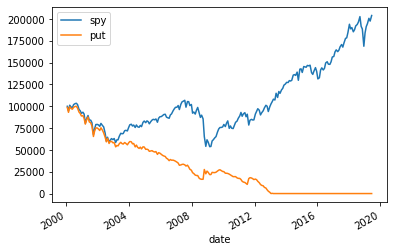

In [203]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)

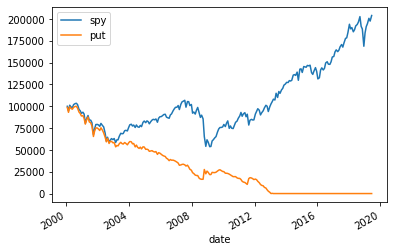

In [204]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)

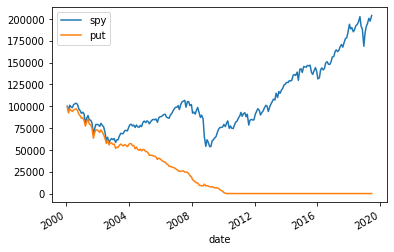

In [205]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.6), maturity_range=(60, 220)),
    100000
)

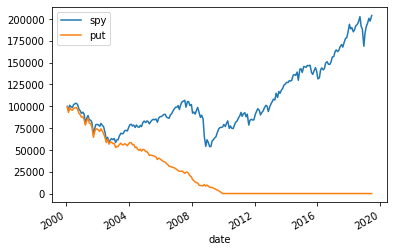

In [206]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.9), maturity_range=(60, 220)),
    100000
)

Hmm, strange, let's sanity check that just a 1 allocation is the same

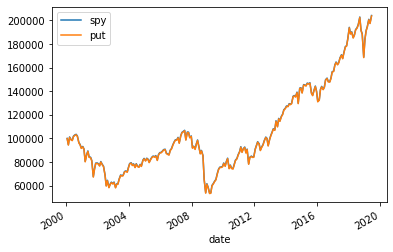

In [218]:
simulate_and_compare(
    build_goal(spx_alloc=1, otm_range=(0.2, 0.9), maturity_range=(60, 220)),
    100000
)

And let's sanity check with a 0.9 allocation -- theoretically because there was a downturn early we should see a bump there

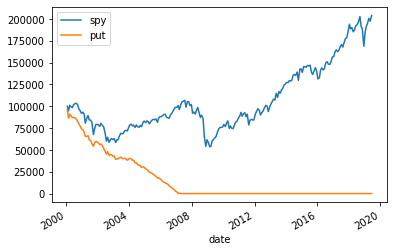

In [209]:
simulate_and_compare(
    build_goal(spx_alloc=0.9, otm_range=(0.2, 0.9), maturity_range=(60, 220)),
    100000
)

## Reflection on Above

Hm..something seems off. With the 0.9 alloc, I would have expected a bump 2000-2004, as the puts should have paid off. 
Maybe the way I am re-allocating is wrong, or the way I am pricing the puts are wrong

## Q Ratio

In [214]:
Q_RARTIO_FILE_PATH = 'tobins_q.csv'
Q_RATIO_DATE_COL = 'date'
Q_RATIO_VALUE_COL = 'value'

def load_q_ratios():
  q_ratios = pd.read_csv(Q_RARTIO_FILE_PATH)
  q_ratios[Q_RATIO_DATE_COL] = pd.to_datetime(q_ratios[Q_RATIO_DATE_COL])
  q_ratios = q_ratios.set_index(Q_RATIO_DATE_COL, drop=False)
  
  return q_ratios


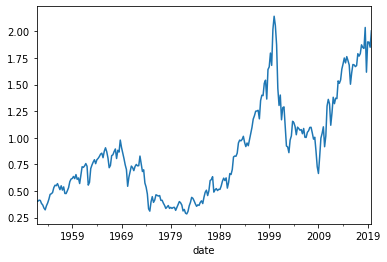

In [215]:
Q_RATIOS = load_q_ratios()
Q_RATIOS[Q_RATIO_VALUE_COL].plot()
plt.show()

In [216]:
def get_q_ratio_for_date(date):
    q_ratios_before_date = Q_RATIOS[Q_RATIOS[Q_RATIO_DATE_COL] < date]
    latest_q_ratio = q_ratios_before_date.last('3D').iloc[0]

    return latest_q_ratio[Q_RATIO_VALUE_COL]

In [217]:
get_q_ratio_for_date(datetime(2000, 1, 3))

2.14224612552741